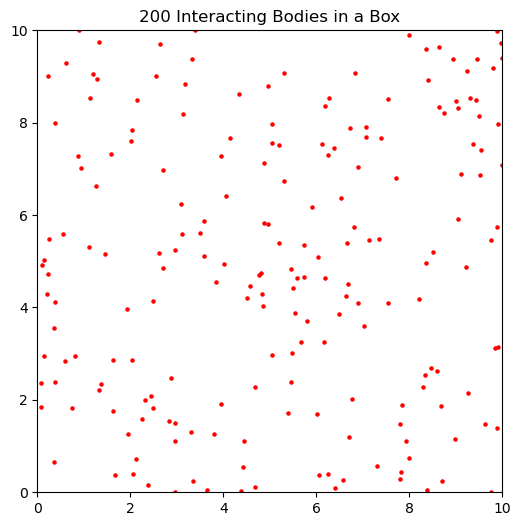

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import cKDTree


class FastMultipoleMethod:
    def __init__(self, positions, masses, G=1.0, dt=0.01, boundary=(0, 10, 0, 10)):
        self.positions = positions
        self.previous_positions = positions - np.random.rand(*positions.shape) * 0.1  # Начальное смещение
        self.masses = masses
        self.G = G
        self.dt = dt
        self.boundary = boundary  # (xmin, xmax, ymin, ymax)
        self.tree = None  

    def update_tree(self):
        self.tree = cKDTree(self.positions)

    def compute_forces(self) -> np.ndarray:
        self.update_tree()
        forces = np.zeros_like(self.positions)
        for i in range(len(self.positions)):
            forces[i] = self._compute_force_on_body(i)
        return forces

    def _compute_force_on_body(self, i: int) -> np.ndarray:
        indices = self.tree.query_ball_point(self.positions[i], r=np.max(self.positions) - np.min(self.positions))
        total_force = np.zeros(2)
        for j in indices:
            if i != j:
                total_force += self._compute_direct_force(i, j)
        return total_force

    def _compute_direct_force(self, i: int, j: int) -> np.ndarray:
        diff = self.positions[j] - self.positions[i]
        dist = np.linalg.norm(diff) + 1e-9  
        force_magnitude = self.G * self.masses[i] * self.masses[j] / dist ** 2
        return force_magnitude * diff / dist

    def apply_boundary_conditions(self):
        xmin, xmax, ymin, ymax = self.boundary
    
        for i in range(len(self.positions)):
            for dim, (low, high) in enumerate(((xmin, xmax), (ymin, ymax))):
                if self.positions[i, dim] < low:
                    prev = self.previous_positions[i, dim]
                    self.positions[i, dim] = low
                    self.previous_positions[i, dim] = 2 * self.positions[i, dim] - prev
    
                if self.positions[i, dim] > high:
                    prev = self.previous_positions[i, dim]
                    self.positions[i, dim] = high
                    self.previous_positions[i, dim] = 2 * self.positions[i, dim] - prev

    def integrate(self):
        forces = self.compute_forces()
        acceleration = forces / self.masses[:, None]

        new_positions = 2 * self.positions - self.previous_positions + acceleration * self.dt**2

        self.previous_positions = self.positions.copy()
        self.positions = new_positions

        self.apply_boundary_conditions()


n_bodies = 200
positions = np.random.rand(n_bodies, 2) * 10
masses = np.random.rand(n_bodies) + 1

fmm = FastMultipoleMethod(positions, masses, dt=0.01, boundary=(0, 10, 0, 10))

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title("200 Interacting Bodies in a Box")
scat = ax.scatter(positions[:, 0], positions[:, 1], c='red', s=5)


def update(frame):
    fmm.integrate()
    scat.set_offsets(fmm.positions)
    return scat,


ani = animation.FuncAnimation(fig, update, frames=200, interval=30, blit=True)
ani.save('N-bodies.gif', writer='ffmpeg', fps=30)

plt.show()
